In [1]:
!pip install fastai==0.7.0 --no-deps
!pip install torch==0.4.1 torchvision==0.2.1

!pip install anaconda bcolz
!pip install anaconda isoweek
!pip install anaconda pandas-summary



     |████████████████████████████████| 122kB 2.7MB/s 
  Found existing installation: fastai 1.0.57
    Uninstalling fastai-1.0.57:
      Successfully uninstalled fastai-1.0.57
     |████████████████████████████████| 519.5MB 48kB/s 
     |████████████████████████████████| 61kB 24.5MB/s 
ERROR: fastai 0.7.0 requires bcolz, which is not installed.
ERROR: fastai 0.7.0 requires isoweek, which is not installed.
ERROR: fastai 0.7.0 requires pandas-summary, which is not installed.
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0
     |████████████████████████████████| 1.5MB 2.7MB/s 
  Created wheel for anaconda: filename=anaconda-0.0.1.1-cp36-none-any.whl size=1124 sha256=6112ca597513e082d49f4e6b704

In [2]:
#imports
import torch
from bokeh.plotting import figure, show, output_notebook, save, output_file

from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

#fastai related imports
import fastai
from fastai.learner import *
from fastai.column_data import *
import seaborn as sns
import sklearn.metrics as metrics

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

torch.cuda.is_available()

True

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

using device: cuda


In [4]:
print(torch.__version__)

0.4.1


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
path='/content/drive/My Drive/Colab Notebooks/' #path to the dataset
data = pd.read_csv(f'{path}testset.csv')
print(data.head())


targets_data_names = data['target_id'].tolist()
cmpds_data_names = data['cmpd_id'].tolist()


   Unnamed: 0        cmpd_id target_id  ...  P97612  P51141  P97266
0           4  CHEMBL3669127    P63085  ...   0.041   0.026   0.084
1           5  CHEMBL3669127    P47811  ...   0.208   0.030   0.113
2           6  CHEMBL2386796    Q9UM73  ...   0.107   0.090   0.023
3           7  CHEMBL3605998    P11103  ...   0.140   0.218   0.045
4           8  CHEMBL3669571    O43614  ...   0.013   0.018   0.128

[5 rows x 804 columns]


In [7]:
data.cmpd_id = data.cmpd_id.astype('category').cat.codes.values
data.target_id = data.target_id.astype('category').cat.codes.values

print(data.head())

data = data[['cmpd_id', 'target_id', 'pKd']] #dropping cells .. not needed for this study
print(len(data))


targets_data_names_dict = dict(zip(data.target_id.to_list(),targets_data_names))

   Unnamed: 0  cmpd_id  target_id       pKd  ...  P51574  P97612  P51141  P97266
0           4     8677        878  5.031517  ...   0.141   0.041   0.026   0.084
1           5     8677        757  5.346787  ...   0.191   0.208   0.030   0.113
2           6     4648       1381  8.619789  ...   0.132   0.107   0.090   0.023
3           7     8300        327  7.522879  ...   0.195   0.140   0.218   0.045
4           8     8734         71  6.818156  ...   0.054   0.013   0.018   0.128

[5 rows x 804 columns]
40218


In [0]:
data.to_csv(f'{path}testset_codes.csv', sep=',', encoding='utf-8', index=False)

# Collaborative filtering using fastai

In [9]:
val_idxs = get_cv_idxs(len(data)) #get validation indices (default 20% of data)
wd=2e-4 #weight decay
n_factors = 50 #how big embedding matrix we want
len(val_idxs)

8043

In [0]:
cf = CollabFilterDataset.from_csv(path, 'testset_codes.csv', 'cmpd_id', 'target_id', 'pKd') #creating a custom dataloader
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam) #create a learner (model) and specify the batch size and optimizer

In [12]:
learn.fit(1e-2, 4, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True) #training with learning rate as 1e-2

epoch      trn_loss   val_loss   
    0      0.619876   1.611879  
    1      0.889906   1.7368    
    2      1.061888   1.476789  
    3      0.983199   1.748484  
    4      0.996039   1.364474  
    5      0.564675   1.194081  
    6      0.274669   1.341421  
    7      1.321401   2.451801  
    8      1.994922   2.341669  
    9      1.50948    1.533064  
    10     0.855452   1.205721  
    11     0.399083   1.089829  
    12     0.153681   1.121153  
    13     0.127266   1.205559  
    14     0.284892   1.460833  



[1.4608332083976108]

In [13]:
preds = learn.predict() #this will predict ratings for validation dataset
preds

array([6.3761 , 7.02384, 7.95926, ..., 8.90344, 9.45437, 9.42774], dtype=float32)

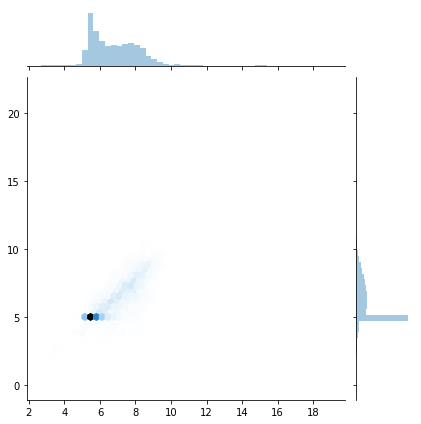

In [14]:
y=learn.data.val_y #actual ratings for validation
sns.jointplot(preds, y, kind='hex', stat_func=None);

In [15]:
math.sqrt(metrics.mean_squared_error(y,preds)) #RMSE for validation data

1.2086493254338262

## Interpreting embeddings and biases

In [0]:
from sklearn.manifold import TSNE

In [24]:

g=data.groupby('target_id')['pKd'].count() #counting the number of interactions for each targets
topTargets=g.sort_values(ascending=False).index.values[:1500] #top 3000 targets based on number of ratings
topTargetsIdx = np.array([cf.item2idx[o] for o in topTargets]) #id for the top targets to link it to the embedding and bias matrix created by the model

len(topTargets)

1419

In [25]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(12867, 50)
  (i): Embedding(1419, 50)
  (ub): Embedding(12867, 1)
  (ib): Embedding(1419, 1)
)

In [26]:
target_emb = to_np(m.i(V(topTargetsIdx))) #converting the torch embedding to numpy matrix
target_emb.shape

(1419, 50)

In [27]:
#t-sne on embedding vectors
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,learning_rate=10)
tsne_results = tsne.fit_transform(target_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1419 samples in 0.009s...
[t-SNE] Computed neighbors for 1419 samples in 0.254s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1419
[t-SNE] Computed conditional probabilities for sample 1419 / 1419
[t-SNE] Mean sigma: 0.059720
[t-SNE] KL divergence after 50 iterations with early exaggeration: 68.437485
[t-SNE] KL divergence after 1000 iterations: 2.403749


In [28]:
topTargets

array([ 500,  733,  387, ...,  797,  794, 1063])

In [0]:
targets_data_names_dict

{0: 'A0A072ZLE6',
 1: 'A3EZI9',
 2: 'O00141',
 3: 'O00238',
 4: 'O00329',
 5: 'O00444',
 6: 'O00506',
 7: 'O00519',
 8: 'O00750',
 9: 'O00763',
 10: 'O14578',
 11: 'O14730',
 12: 'O14733',
 13: 'O14757',
 14: 'O14920',
 15: 'O14936',
 16: 'O14965',
 17: 'O14976',
 18: 'O15075',
 19: 'O15111',
 20: 'O15146',
 21: 'O15197',
 22: 'O15264',
 23: 'O15294',
 24: 'O15530',
 25: 'O43283',
 26: 'O43293',
 27: 'O43318',
 28: 'O43353',
 29: 'O43683',
 30: 'O60285',
 31: 'O60331',
 32: 'O60341',
 33: 'O60674',
 34: 'O60885',
 35: 'O75116',
 36: 'O75385',
 37: 'O75460',
 38: 'O75582',
 39: 'O75676',
 40: 'O75716',
 41: 'O75747',
 42: 'O75914',
 43: 'O76039',
 44: 'O94768',
 45: 'O94804',
 46: 'O94806',
 47: 'O94921',
 48: 'O95382',
 49: 'O95696',
 50: 'O95747',
 51: 'O95819',
 52: 'O96013',
 53: 'O96017',
 54: 'P00519',
 55: 'P00533',
 56: 'P03428',
 57: 'P04035',
 58: 'P04049',
 59: 'P04062',
 60: 'P04626',
 61: 'P04629',
 62: 'P05067',
 63: 'P05106',
 64: 'P05107',
 65: 'P05362',
 66: 'P06213',
 

In [29]:
#preparing dataframe for visualization
df_combine = pd.DataFrame([targets_data_names_dict[i] for i in topTargets])
df_combine.columns = ['title']
df_combine['x-tsne'] = tsne_results[:,0]
df_combine['y-tsne'] = tsne_results[:,1]
df_combine.head()

,title,x-tsne,y-tsne
0,P23944,1.970244,-19.652605
1,P43140,1.766872,-19.555288
2,P15823,1.948926,-19.888126
3,P30556,3.962288,10.435190
4,P50052,4.049372,10.436996


In [0]:
df_combine.to_csv(f'{path}tsne-2comp.csv')

### **Visualizing t-SNE components of embeddings using Bokeh**

In [0]:
source = ColumnDataSource(dict(
    x=df_combine['x-tsne'],
    y=df_combine['y-tsne'],
    title= df_combine['title']
))

In [32]:
import plotly as py

#output_file('t-SNE_emb.html')

title = 'T-SNE visualization of embeddings'

plot_lda = figure(plot_width=1000, plot_height=600,
                         title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                         x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,
                    alpha=0.4, size=10)

show(plot_lda)

#save(plot_lda, 't-SNE_emb.html') #this will save the plot as html

#save(plot_lda, f'{path}t-SNE_emb.html')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}
    


### Cosine similarity in embedding space


In [0]:
def cos_sim(a, b):
	"""Takes 2 vectors a, b and returns the cosine similarity according 
	to the definition of the dot product
	"""
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

In [34]:
title2emb = pd.DataFrame([targets_data_names_dict[i] for i in topTargets])
title2emb.columns = ['title']
title2emb = pd.concat([title2emb,pd.DataFrame(target_emb)],axis =1)
title2emb.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,P23944,-0.001042,0.012985,0.062271,0.008223,-0.069667,0.001774,0.008394,-0.049330,0.045630,0.062598,0.028892,0.008514,-0.221526,0.021367,-0.014812,0.041357,0.017007,0.053354,0.000419,0.180575,0.004966,-0.042490,0.021878,-0.038729,0.034954,0.019105,-0.022163,0.027635,-0.007384,-0.034523,0.021474,-0.002408,-0.007101,-0.056225,0.033000,0.003994,-0.005715,0.020894,0.015934,0.086273,0.042243,0.022843,-0.021825,0.022036,0.031886,-0.098361,0.047140,-0.039720,-0.002429,0.060862
1,P43140,-0.000929,0.067521,0.014842,-0.006411,-0.027193,0.014321,-0.022424,-0.079065,0.000450,0.029934,0.022679,0.116722,-0.155119,-0.007584,0.025737,-0.006885,0.067812,0.008280,-0.009860,0.180178,-0.028561,-0.064209,-0.004844,-0.044239,-0.030775,0.019788,-0.014908,0.058010,-0.028604,0.009537,0.055095,-0.085158,0.009372,-0.018052,-0.003871,0.006469,0.039942,0.021391,-0.015991,0.029324,0.031113,0.014949,-0.030519,0.018672,0.018295,-0.052185,0.041365,0.001605,0.013689,0.057593
2,P15823,0.043126,0.016532,-0.004287,0.067283,-0.099948,-0.002231,-0.016197,-0.047357,0.016784,0.026232,0.059051,-0.012901,-0.133892,0.015079,-0.051597,-0.026106,-0.000568,0.016424,0.034812,0.288853,0.018515,-0.037529,-0.034216,-0.036907,0.057126,-0.010770,-0.022890,0.025935,-0.032572,-0.014009,0.060383,-0.005825,-0.007356,0.029898,0.062413,0.023477,-0.013892,0.012000,0.020617,0.072699,0.024280,0.023489,0.000314,-0.003963,-0.002391,-0.047031,-0.025844,-0.019923,0.027352,0.015932
3,P30556,-0.052142,-0.048829,-0.007522,0.005639,-0.027583,-0.047675,0.013311,0.028169,0.011272,-0.021817,0.018539,-0.002249,0.014955,-0.014379,0.012794,0.021697,-0.014401,0.018725,0.043601,0.015006,0.008733,-0.019155,-0.042318,-0.018371,-0.064807,-0.009257,-0.026880,-0.006587,0.050522,-0.003171,0.035925,-0.046210,0.021899,-0.080834,0.058757,-0.010553,-0.009469,-0.021862,0.042969,0.006683,0.046587,-0.038339,-0.031556,0.025905,0.004505,-0.015740,-0.048290,0.009185,-0.047598,-0.069487
4,P50052,-0.032224,-0.045630,-0.005335,0.011236,-0.010927,-0.041256,0.015691,0.041649,0.016471,-0.018286,-0.001431,-0.016044,0.018385,-0.022381,-0.011233,0.032550,-0.033519,0.035494,0.035643,0.009836,0.031054,0.016026,-0.040824,0.000537,-0.061292,-0.009483,-0.006038,0.010764,0.041242,0.003052,0.046652,-0.032245,0.004164,-0.076808,0.074022,-0.001076,-0.004552,0.006703,0.038875,-0.002960,0.046958,-0.053321,-0.034028,0.019636,-0.019177,-0.037484,-0.053643,-0.003105,-0.043633,-0.078015


In [35]:
base_target = title2emb['title'][0]
print(len(title2emb))
base_target

1419


'P23944'

In [36]:
title2emb['title'].values[300]

'Q9Y2H1'

In [37]:
base_target = title2emb['title'].values[300]
base_emb = title2emb[title2emb['title']==base_target].iloc[:,1:].values #embedding vector for the base target
target_list = title2emb.title
cos_sim_dict = {i:cos_sim(np.squeeze(base_emb),np.squeeze(title2emb[title2emb['title']==i].iloc[:,1:].values)) for i in target_list}
sorted(cos_sim_dict.items(), key=itemgetter(1),reverse=True)[:15] #targets sorted by cosine similarity to the base target

[('Q9Y2H1', 1.0),
 ('Q04912', 0.53577536),
 ('O75914', 0.46967998),
 ('Q9H3Y6', 0.42054597),
 ('Q8VH27', 0.4169678),
 ('Q9Y6R4', 0.40160954),
 ('Q12852', 0.4013874),
 ('P41594', 0.39377934),
 ('P56817', 0.37393287),
 ('Q9UKI8', 0.37231004),
 ('P10636', 0.3633179),
 ('O75899', 0.35906476),
 ('O95382', 0.35808265),
 ('Q15375', 0.357716),
 ('P48039', 0.35342506)]

### Target bias

In [38]:
target_bias = to_np(m.ib(V(topTargetsIdx))) #extracting the target bias from the trained model for 3000 targets
target_bias

array([[-0.53151],
       [-0.54956],
       [-0.54801],
       ...,
       [-0.17879],
       [-0.22047],
       [-0.16965]], dtype=float32)

In [0]:
target_pKd = [(b[0], targets_data_names_dict[i]) for i,b in zip(topTargets,target_bias)]

In [40]:
sorted(target_pKd, key=lambda o: o[0])[:15] #worst targets based on bias pKd

[(-1.0636768, 'P03120'),
 (-0.95609784, 'Q99816'),
 (-0.95532733, 'P62942'),
 (-0.86763257, 'P34158'),
 (-0.8503632, 'P00338'),
 (-0.84137076, 'P00720'),
 (-0.8317459, 'P09382'),
 (-0.8195556, 'O00214'),
 (-0.8186504, 'A3EZI9'),
 (-0.81172234, 'P47929'),
 (-0.8032303, 'P02768'),
 (-0.7948459, 'P45040'),
 (-0.79470295, 'P56817'),
 (-0.7846905, 'P80193'),
 (-0.7781251, 'Q14145')]

In [41]:
sorted(target_pKd, key=lambda o: o[0], reverse=True)[:15] #top targets based on bias pKd

[(0.32821068, 'P48039'),
 (0.3242369, 'P49286'),
 (0.2965801, 'P34971'),
 (0.2827672, 'P18762'),
 (0.20607235, 'P25962'),
 (0.19377282, 'P32246'),
 (0.12890297, 'P0AF12'),
 (0.123046845, 'P25779'),
 (0.11875094, 'P00469'),
 (0.07657114, 'A3RGC1'),
 (0.07043669, 'P31652'),
 (0.05940679, 'O08858'),
 (0.051902223, 'P20288'),
 (0.04160195, 'P00760'),
 (0.040161453, 'P79350')]

### Looking at a particular compound

In [42]:
u=data.groupby('cmpd_id')['pKd'].count()
topcmpds=u.sort_values(ascending=False).index.values[:100]
topcmpds_idx = np.array([cf.user2idx[o] for o in topcmpds])

topcmpds

array([11944,  9521, 11785, 11913,  1335,  3540,  5193,  2291,  1447, 11757, 11760,  3725,  5248,  5861,
        9460, 11213,  1259, 11350, 11075,  1007,  2780,  2472,  9113,  2782,  9179,  2779,  2778,  3896,
        1253, 11940,    73,  5924,  1966,  1028, 10441, 10183, 11619,   758, 12767, 11630,  1018, 10777,
       10355,  5575,  4848,   290, 12209, 11103,  2517,  7077,  7079,  5029,  7078,  3546,  8162,  6704,
        7146,  7131, 12784,  3465,  3466,  3482,  3483,  5698,  5730,  6437, 12797,  1844,  9567,  9511,
         746, 11291, 12834, 12826, 12822,  1254,  9579,  2298,  7931,  8462,  5919, 12049,  5522,   604,
        5513,  8163,  5727,   771,  2667,  7903,  8196, 12309,  8195,  7266,  1665,  4083,  7675,  8194,
        5584,  5393])

In [0]:
p = 11944

cmpd_p = data[data['cmpd_id']==p] #cmpd with the highest number of interactions
uptarget_idx = np.array([cf.item2idx[o] for o in cmpd_p.target_id]) #id for the top targets to link it to the embedding and bias matrix created by the model
up_pKd = cmpd_p.pKd
target_emb_up = to_np(m.i(V(uptarget_idx))) #converting the torch embedding to numpy matrix

In [0]:
df_combine_up = pd.DataFrame([targets_data_names_dict[i] for i in cmpd_p.target_id])
df_combine_up.columns = ['title']
df_combine_up = pd.concat([df_combine_up,pd.DataFrame(target_emb_up)],axis=1)

In [46]:
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,Q9Y6R4,-0.007450,-0.033586,0.110789,-0.107398,-0.071392,0.004037,-0.082946,0.076634,-0.045388,0.038412,-0.049491,-0.074282,-0.021140,-0.086751,-0.000839,-0.090133,0.098609,-0.029739,0.022312,-0.021160,0.159906,0.032792,0.168016,-0.014652,0.063848,0.041218,-0.058222,-0.038202,-0.041567,-0.035769,-0.036144,-0.027104,0.200239,0.086391,0.141665,-0.009358,-0.077087,0.063844,0.218509,-0.027148,0.040425,0.026288,0.068607,0.138231,0.052040,0.081982,-0.068294,0.181003,-0.135909,0.031062
1,Q9Y6M4,0.042257,-0.038740,-0.054371,-0.138246,0.063551,-0.014204,-0.114041,0.021303,0.049768,-0.065385,-0.071483,0.027138,-0.174940,0.081208,0.043236,0.095158,0.056738,-0.062996,0.325117,0.132580,0.042586,-0.080292,-0.025099,-0.070778,0.178213,0.030700,-0.076507,-0.186484,-0.044895,0.003578,0.042377,-0.045533,0.053477,-0.037492,0.212582,-0.027710,-0.219467,0.145071,0.020833,-0.057969,0.026051,0.020217,-0.042236,-0.058215,-0.067613,0.247048,0.004845,0.140496,-0.009260,0.272842
2,Q9Y6E0,0.042180,0.084908,0.060244,0.003353,-0.001066,0.067838,-0.157529,-0.029022,0.107183,0.197011,0.004588,-0.220084,-0.024128,0.018014,0.000917,-0.027027,-0.009043,-0.098066,0.092759,-0.004501,0.057384,0.107057,-0.156058,0.106068,-0.077670,0.127101,0.018073,0.036261,-0.169057,0.122350,-0.017283,-0.010053,-0.032481,-0.060132,-0.081321,0.025180,-0.088854,-0.128939,0.067891,0.024018,0.024612,0.011129,-0.115795,-0.027616,0.036304,0.175479,0.011341,0.099655,-0.011310,0.020154
3,Q9Y616,-0.068207,0.078437,0.053311,0.036600,0.083434,-0.065049,-0.035494,0.022630,0.002936,-0.129942,-0.048279,0.016590,0.057592,-0.033243,0.221450,-0.132634,0.073063,0.062045,0.100681,-0.117402,-0.158655,0.224574,-0.088774,0.043772,0.140395,-0.026560,0.040807,-0.067877,-0.066792,-0.248145,0.089135,0.165057,0.027414,-0.144891,-0.064042,-0.015736,0.118197,0.086184,-0.037540,0.136879,-0.043199,0.088423,0.104910,-0.106063,-0.158485,0.031240,0.088492,0.179145,0.061822,-0.151611
4,Q9Y5S2,0.103505,0.035555,-0.044804,0.106757,-0.078438,-0.076873,-0.016478,0.124343,-0.064787,-0.039157,0.012545,0.001436,-0.061963,-0.045171,-0.152454,-0.087685,0.027107,-0.064564,0.088767,-0.011455,0.166328,-0.009416,-0.014911,0.109458,-0.052617,0.109989,-0.131137,-0.114785,0.115862,-0.039372,0.104650,-0.199337,-0.102236,0.133764,0.089650,0.131964,-0.120974,0.153737,-0.007442,-0.100471,-0.167210,0.078841,0.093386,0.084656,-0.160802,0.065809,0.075879,0.177066,-0.093466,-0.056459


In [47]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,learning_rate=10)
tsne_results = tsne.fit_transform(target_emb_up)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 385 samples in 0.001s...
[t-SNE] Computed neighbors for 385 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 385 / 385
[t-SNE] Mean sigma: 0.291401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.735870
[t-SNE] KL divergence after 1000 iterations: 1.317364


In [48]:
df_combine_up['x-tsne'] = tsne_results[:,0]
df_combine_up['y-tsne'] = tsne_results[:,1]
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne
0,Q9Y6R4,-0.007450,-0.033586,0.110789,-0.107398,-0.071392,0.004037,-0.082946,0.076634,-0.045388,0.038412,-0.049491,-0.074282,-0.021140,-0.086751,-0.000839,-0.090133,0.098609,-0.029739,0.022312,-0.021160,0.159906,0.032792,0.168016,-0.014652,0.063848,0.041218,-0.058222,-0.038202,-0.041567,-0.035769,-0.036144,-0.027104,0.200239,0.086391,0.141665,-0.009358,-0.077087,0.063844,0.218509,-0.027148,0.040425,0.026288,0.068607,0.138231,0.052040,0.081982,-0.068294,0.181003,-0.135909,0.031062,2.636570,1.933194
1,Q9Y6M4,0.042257,-0.038740,-0.054371,-0.138246,0.063551,-0.014204,-0.114041,0.021303,0.049768,-0.065385,-0.071483,0.027138,-0.174940,0.081208,0.043236,0.095158,0.056738,-0.062996,0.325117,0.132580,0.042586,-0.080292,-0.025099,-0.070778,0.178213,0.030700,-0.076507,-0.186484,-0.044895,0.003578,0.042377,-0.045533,0.053477,-0.037492,0.212582,-0.027710,-0.219467,0.145071,0.020833,-0.057969,0.026051,0.020217,-0.042236,-0.058215,-0.067613,0.247048,0.004845,0.140496,-0.009260,0.272842,4.942221,0.615893
2,Q9Y6E0,0.042180,0.084908,0.060244,0.003353,-0.001066,0.067838,-0.157529,-0.029022,0.107183,0.197011,0.004588,-0.220084,-0.024128,0.018014,0.000917,-0.027027,-0.009043,-0.098066,0.092759,-0.004501,0.057384,0.107057,-0.156058,0.106068,-0.077670,0.127101,0.018073,0.036261,-0.169057,0.122350,-0.017283,-0.010053,-0.032481,-0.060132,-0.081321,0.025180,-0.088854,-0.128939,0.067891,0.024018,0.024612,0.011129,-0.115795,-0.027616,0.036304,0.175479,0.011341,0.099655,-0.011310,0.020154,-6.054338,-1.911019
3,Q9Y616,-0.068207,0.078437,0.053311,0.036600,0.083434,-0.065049,-0.035494,0.022630,0.002936,-0.129942,-0.048279,0.016590,0.057592,-0.033243,0.221450,-0.132634,0.073063,0.062045,0.100681,-0.117402,-0.158655,0.224574,-0.088774,0.043772,0.140395,-0.026560,0.040807,-0.067877,-0.066792,-0.248145,0.089135,0.165057,0.027414,-0.144891,-0.064042,-0.015736,0.118197,0.086184,-0.037540,0.136879,-0.043199,0.088423,0.104910,-0.106063,-0.158485,0.031240,0.088492,0.179145,0.061822,-0.151611,-0.949433,0.117661
4,Q9Y5S2,0.103505,0.035555,-0.044804,0.106757,-0.078438,-0.076873,-0.016478,0.124343,-0.064787,-0.039157,0.012545,0.001436,-0.061963,-0.045171,-0.152454,-0.087685,0.027107,-0.064564,0.088767,-0.011455,0.166328,-0.009416,-0.014911,0.109458,-0.052617,0.109989,-0.131137,-0.114785,0.115862,-0.039372,0.104650,-0.199337,-0.102236,0.133764,0.089650,0.131964,-0.120974,0.153737,-0.007442,-0.100471,-0.167210,0.078841,0.093386,0.084656,-0.160802,0.065809,0.075879,0.177066,-0.093466,-0.056459,3.284209,-2.319628


In [49]:
df_combine_up['pKd'] = cmpd_p.pKd.reset_index()['pKd']
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne,pKd
0,Q9Y6R4,-0.007450,-0.033586,0.110789,-0.107398,-0.071392,0.004037,-0.082946,0.076634,-0.045388,0.038412,-0.049491,-0.074282,-0.021140,-0.086751,-0.000839,-0.090133,0.098609,-0.029739,0.022312,-0.021160,0.159906,0.032792,0.168016,-0.014652,0.063848,0.041218,-0.058222,-0.038202,-0.041567,-0.035769,-0.036144,-0.027104,0.200239,0.086391,0.141665,-0.009358,-0.077087,0.063844,0.218509,-0.027148,0.040425,0.026288,0.068607,0.138231,0.052040,0.081982,-0.068294,0.181003,-0.135909,0.031062,2.636570,1.933194,5.000000
1,Q9Y6M4,0.042257,-0.038740,-0.054371,-0.138246,0.063551,-0.014204,-0.114041,0.021303,0.049768,-0.065385,-0.071483,0.027138,-0.174940,0.081208,0.043236,0.095158,0.056738,-0.062996,0.325117,0.132580,0.042586,-0.080292,-0.025099,-0.070778,0.178213,0.030700,-0.076507,-0.186484,-0.044895,0.003578,0.042377,-0.045533,0.053477,-0.037492,0.212582,-0.027710,-0.219467,0.145071,0.020833,-0.057969,0.026051,0.020217,-0.042236,-0.058215,-0.067613,0.247048,0.004845,0.140496,-0.009260,0.272842,4.942221,0.615893,5.000000
2,Q9Y6E0,0.042180,0.084908,0.060244,0.003353,-0.001066,0.067838,-0.157529,-0.029022,0.107183,0.197011,0.004588,-0.220084,-0.024128,0.018014,0.000917,-0.027027,-0.009043,-0.098066,0.092759,-0.004501,0.057384,0.107057,-0.156058,0.106068,-0.077670,0.127101,0.018073,0.036261,-0.169057,0.122350,-0.017283,-0.010053,-0.032481,-0.060132,-0.081321,0.025180,-0.088854,-0.128939,0.067891,0.024018,0.024612,0.011129,-0.115795,-0.027616,0.036304,0.175479,0.011341,0.099655,-0.011310,0.020154,-6.054338,-1.911019,5.000000
3,Q9Y616,-0.068207,0.078437,0.053311,0.036600,0.083434,-0.065049,-0.035494,0.022630,0.002936,-0.129942,-0.048279,0.016590,0.057592,-0.033243,0.221450,-0.132634,0.073063,0.062045,0.100681,-0.117402,-0.158655,0.224574,-0.088774,0.043772,0.140395,-0.026560,0.040807,-0.067877,-0.066792,-0.248145,0.089135,0.165057,0.027414,-0.144891,-0.064042,-0.015736,0.118197,0.086184,-0.037540,0.136879,-0.043199,0.088423,0.104910,-0.106063,-0.158485,0.031240,0.088492,0.179145,0.061822,-0.151611,-0.949433,0.117661,6.744727
4,Q9Y5S2,0.103505,0.035555,-0.044804,0.106757,-0.078438,-0.076873,-0.016478,0.124343,-0.064787,-0.039157,0.012545,0.001436,-0.061963,-0.045171,-0.152454,-0.087685,0.027107,-0.064564,0.088767,-0.011455,0.166328,-0.009416,-0.014911,0.109458,-0.052617,0.109989,-0.131137,-0.114785,0.115862,-0.039372,0.104650,-0.199337,-0.102236,0.133764,0.089650,0.131964,-0.120974,0.153737,-0.007442,-0.100471,-0.167210,0.078841,0.093386,0.084656,-0.160802,0.065809,0.075879,0.177066,-0.093466,-0.056459,3.284209,-2.319628,5.000000


In [0]:
df_combine_up.to_csv(f'{path}tsne_2comp_up.csv')

### Visualizing t-SNE components of embeddings using Bokeh

In [0]:
df_combine_up['pKd_bin'] = pd.cut(df_combine_up.pKd,5,labels=[0,1,2,3,4]) #creating bins from the ratings

In [52]:
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne,pKd,pKd_bin
0,Q9Y6R4,-0.007450,-0.033586,0.110789,-0.107398,-0.071392,0.004037,-0.082946,0.076634,-0.045388,0.038412,-0.049491,-0.074282,-0.021140,-0.086751,-0.000839,-0.090133,0.098609,-0.029739,0.022312,-0.021160,0.159906,0.032792,0.168016,-0.014652,0.063848,0.041218,-0.058222,-0.038202,-0.041567,-0.035769,-0.036144,-0.027104,0.200239,0.086391,0.141665,-0.009358,-0.077087,0.063844,0.218509,-0.027148,0.040425,0.026288,0.068607,0.138231,0.052040,0.081982,-0.068294,0.181003,-0.135909,0.031062,2.636570,1.933194,5.000000,0
1,Q9Y6M4,0.042257,-0.038740,-0.054371,-0.138246,0.063551,-0.014204,-0.114041,0.021303,0.049768,-0.065385,-0.071483,0.027138,-0.174940,0.081208,0.043236,0.095158,0.056738,-0.062996,0.325117,0.132580,0.042586,-0.080292,-0.025099,-0.070778,0.178213,0.030700,-0.076507,-0.186484,-0.044895,0.003578,0.042377,-0.045533,0.053477,-0.037492,0.212582,-0.027710,-0.219467,0.145071,0.020833,-0.057969,0.026051,0.020217,-0.042236,-0.058215,-0.067613,0.247048,0.004845,0.140496,-0.009260,0.272842,4.942221,0.615893,5.000000,0
2,Q9Y6E0,0.042180,0.084908,0.060244,0.003353,-0.001066,0.067838,-0.157529,-0.029022,0.107183,0.197011,0.004588,-0.220084,-0.024128,0.018014,0.000917,-0.027027,-0.009043,-0.098066,0.092759,-0.004501,0.057384,0.107057,-0.156058,0.106068,-0.077670,0.127101,0.018073,0.036261,-0.169057,0.122350,-0.017283,-0.010053,-0.032481,-0.060132,-0.081321,0.025180,-0.088854,-0.128939,0.067891,0.024018,0.024612,0.011129,-0.115795,-0.027616,0.036304,0.175479,0.011341,0.099655,-0.011310,0.020154,-6.054338,-1.911019,5.000000,0
3,Q9Y616,-0.068207,0.078437,0.053311,0.036600,0.083434,-0.065049,-0.035494,0.022630,0.002936,-0.129942,-0.048279,0.016590,0.057592,-0.033243,0.221450,-0.132634,0.073063,0.062045,0.100681,-0.117402,-0.158655,0.224574,-0.088774,0.043772,0.140395,-0.026560,0.040807,-0.067877,-0.066792,-0.248145,0.089135,0.165057,0.027414,-0.144891,-0.064042,-0.015736,0.118197,0.086184,-0.037540,0.136879,-0.043199,0.088423,0.104910,-0.106063,-0.158485,0.031240,0.088492,0.179145,0.061822,-0.151611,-0.949433,0.117661,6.744727,2
4,Q9Y5S2,0.103505,0.035555,-0.044804,0.106757,-0.078438,-0.076873,-0.016478,0.124343,-0.064787,-0.039157,0.012545,0.001436,-0.061963,-0.045171,-0.152454,-0.087685,0.027107,-0.064564,0.088767,-0.011455,0.166328,-0.009416,-0.014911,0.109458,-0.052617,0.109989,-0.131137,-0.114785,0.115862,-0.039372,0.104650,-0.199337,-0.102236,0.133764,0.089650,0.131964,-0.120974,0.153737,-0.007442,-0.100471,-0.167210,0.078841,0.093386,0.084656,-0.160802,0.065809,0.075879,0.177066,-0.093466,-0.056459,3.284209,-2.319628,5.000000,0


In [0]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'black'} #assigning colors for each bin

In [0]:
df_combine_up['colors'] = df_combine_up['pKd_bin'].apply(lambda l: cluster_colors[l]) #creating color column in the df

In [55]:
df_combine_up.head()

,title,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,x-tsne,y-tsne,pKd,pKd_bin,colors
0,Q9Y6R4,-0.007450,-0.033586,0.110789,-0.107398,-0.071392,0.004037,-0.082946,0.076634,-0.045388,0.038412,-0.049491,-0.074282,-0.021140,-0.086751,-0.000839,-0.090133,0.098609,-0.029739,0.022312,-0.021160,0.159906,0.032792,0.168016,-0.014652,0.063848,0.041218,-0.058222,-0.038202,-0.041567,-0.035769,-0.036144,-0.027104,0.200239,0.086391,0.141665,-0.009358,-0.077087,0.063844,0.218509,-0.027148,0.040425,0.026288,0.068607,0.138231,0.052040,0.081982,-0.068294,0.181003,-0.135909,0.031062,2.636570,1.933194,5.000000,0,blue
1,Q9Y6M4,0.042257,-0.038740,-0.054371,-0.138246,0.063551,-0.014204,-0.114041,0.021303,0.049768,-0.065385,-0.071483,0.027138,-0.174940,0.081208,0.043236,0.095158,0.056738,-0.062996,0.325117,0.132580,0.042586,-0.080292,-0.025099,-0.070778,0.178213,0.030700,-0.076507,-0.186484,-0.044895,0.003578,0.042377,-0.045533,0.053477,-0.037492,0.212582,-0.027710,-0.219467,0.145071,0.020833,-0.057969,0.026051,0.020217,-0.042236,-0.058215,-0.067613,0.247048,0.004845,0.140496,-0.009260,0.272842,4.942221,0.615893,5.000000,0,blue
2,Q9Y6E0,0.042180,0.084908,0.060244,0.003353,-0.001066,0.067838,-0.157529,-0.029022,0.107183,0.197011,0.004588,-0.220084,-0.024128,0.018014,0.000917,-0.027027,-0.009043,-0.098066,0.092759,-0.004501,0.057384,0.107057,-0.156058,0.106068,-0.077670,0.127101,0.018073,0.036261,-0.169057,0.122350,-0.017283,-0.010053,-0.032481,-0.060132,-0.081321,0.025180,-0.088854,-0.128939,0.067891,0.024018,0.024612,0.011129,-0.115795,-0.027616,0.036304,0.175479,0.011341,0.099655,-0.011310,0.020154,-6.054338,-1.911019,5.000000,0,blue
3,Q9Y616,-0.068207,0.078437,0.053311,0.036600,0.083434,-0.065049,-0.035494,0.022630,0.002936,-0.129942,-0.048279,0.016590,0.057592,-0.033243,0.221450,-0.132634,0.073063,0.062045,0.100681,-0.117402,-0.158655,0.224574,-0.088774,0.043772,0.140395,-0.026560,0.040807,-0.067877,-0.066792,-0.248145,0.089135,0.165057,0.027414,-0.144891,-0.064042,-0.015736,0.118197,0.086184,-0.037540,0.136879,-0.043199,0.088423,0.104910,-0.106063,-0.158485,0.031240,0.088492,0.179145,0.061822,-0.151611,-0.949433,0.117661,6.744727,2,yellow
4,Q9Y5S2,0.103505,0.035555,-0.044804,0.106757,-0.078438,-0.076873,-0.016478,0.124343,-0.064787,-0.039157,0.012545,0.001436,-0.061963,-0.045171,-0.152454,-0.087685,0.027107,-0.064564,0.088767,-0.011455,0.166328,-0.009416,-0.014911,0.109458,-0.052617,0.109989,-0.131137,-0.114785,0.115862,-0.039372,0.104650,-0.199337,-0.102236,0.133764,0.089650,0.131964,-0.120974,0.153737,-0.007442,-0.100471,-0.167210,0.078841,0.093386,0.084656,-0.160802,0.065809,0.075879,0.177066,-0.093466,-0.056459,3.284209,-2.319628,5.000000,0,blue


In [0]:
top_labels = {0: 'V. Low', 1:'Low', 2:'Medium', 3:'High',4:'V.High'} #actual range of bins

In [0]:
source = ColumnDataSource(dict(
    x=df_combine_up['x-tsne'],
    y=df_combine_up['y-tsne'],
    title= df_combine_up['title'], #title for tool tip
    colors = df_combine_up['colors'], #colors for each point according to cluster/bin
    label=df_combine_up['pKd_bin'].apply(lambda l: top_labels[l]) #label for each cluster/bin
))

In [58]:
df_combine_up['x-tsne'].shape

(385,)

In [59]:
title = 'T-SNE visualization of embeddings- cluster by cmpd pKd (cmpd_id:725)'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,legend='label',
                alpha=0.8, color='colors',)

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}

plot_lda.legend.location = "top_left"
plot_lda.legend.orientation = "horizontal"
show(plot_lda)


#save(plot_lda, '{}.html'.format(title))

#save(plot_lda, f'{path}t-SNE_cluster_rating.html')

### Embeddings cluster by bias

In [0]:
df_combine['bias'] = target_bias


In [0]:
df_combine['bias_bin'] = pd.cut(df_combine.bias,5,labels=[0,1,2,3,4])

In [0]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'black'}

df_combine['colors'] = df_combine['bias_bin'].apply(lambda l: cluster_colors[l])

df_combine.head()

top_labels1 = {0: 'V. Low', 1:'Low', 2:'Medium', 3:'High',4:'V.High'}

In [0]:
df_combine.to_csv(f'{path}tsne_2comp_bias.csv')

In [64]:
source = ColumnDataSource(dict(
    x=df_combine['x-tsne'],
    y=df_combine['y-tsne'],
    title= df_combine['title'],
    colors = df_combine['colors'],
    label=df_combine['bias_bin'].apply(lambda l: top_labels1[l])

))

title = 'T-SNE visualization of embeddings - cluster by bias'

plot_lda = figure(plot_width=1000, plot_height=800,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,legend='label',
                alpha=0.8, color='colors')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}


plot_lda.legend.location = "top_left"

plot_lda.legend.orientation = "horizontal"

show(plot_lda)
#save(plot_lda, 't-SNE_emb_cluster_bias.html')